# Exercise - Create a Text2SQL Agent - STARTER

In this exercise, you’ll build an AI agent capable of converting natural language questions into SQL queries, executing them, and returning the results.

**Challenge**

You’re building a Text2SQL assistant for a Sales Dashboard.
The agent should:

- Parse user questions.
- Identify the relevant tables and columns.
- Generate the corresponding SQL query.
- Execute the query and return the result.

This enables non-technical users to ask questions in plain English and get data insights without writing SQL.

## 0. Import the necessary libs

In [1]:
from typing import TypedDict, List, Annotated
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from sqlalchemy import create_engine

from sql_toolkit import (
    list_tables_tool, 
    get_table_schema_tool, 
    execute_sql_tool
)

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [2]:
OPENAI_API_KEY="voc-*"

In [3]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key = OPENAI_API_KEY,
)

## 2. Initialize the State Graph

You can either chose from creating it with TypedDict, Pydantic or using the MessagesState. It should store:

- user_query: The user's natural language question.
- messages: The conversation history.

In [4]:
# TODO - Instantiate your workflow passing a State Schema
class State(MessagesState):
    user_query: str # The user's natural language question.
    messages: Annotated[List[AnyMessage], add_messages] # The conversation history.

workflow = StateGraph(State)

## 3. Define the tools available

We created the following tools:
- list_tables_tool: Lists tables in the database., 
- get_table_schema_tool: Retrieves the schema of a specific table, 
- execute_sql_tool: Executes the generated SQL query.

They are all accessible in the sql_toolkit.py. It's already imported. You need to add them to the tools list, then add the tools list to a node and bind the tools to the llm.

In [5]:
# TODO - create a list with the tools
dba_tools = [list_tables_tool, get_table_schema_tool, execute_sql_tool]

In [6]:
workflow.add_node("dba_tools", ToolNode(dba_tools))

In [7]:
dba_llm = llm.bind_tools(dba_tools, tool_choice="auto")

## 4. The agent node

Before creating the dba_agent node, you need to build the initial messages to start the conversation. So, we'll first create the messages builder node.

The llm you'll use has already the tools bound to it, so the message will have a content or a tool_calls.

In [8]:
def messages_builder(state: State):
    dba_sys_msg = (
        "You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:\n"
        "First, find out the appropriate table name based on all tables. "
        "Then get the table's schema to understand the columns. "
        "With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. "
        "Finally, use a tool to execute the above SQL query and output the result based on the user question."
    )
    messages = [
        SystemMessage(dba_sys_msg),
        HumanMessage(state["user_query"])
    ]
    return {"messages": messages}

In [9]:
def dba_agent(state: State):
#     ai_message = dba_llm.invoke(state["messages"])
#     ai_message.name = "dba_agent"
    response = dba_llm.invoke(state["messages"])
    return {"messages": response}

In [10]:
# TODO - Add both nodes
workflow.add_node("messages_builder", messages_builder)
workflow.add_node("dba_agent", dba_agent)

## 5. Edges

To enable the cycle, you need to have a routing function. This function:

- Inspects the conversation history.
- Decides whether to call a tool or end the workflow.

Then, create the nodes:
- After the START entrypoint, you need to move to messages_builder
- From messages_builder, to the dba_agent
- The dba_agent should call the routing_function within a conditional edge
- If the response is a tool_call, send to dba_tools node
- Else, terminates in the END termination node.

In [11]:
# TODO - Your conditional function to route between dba_tools or END
def should_continue(state: State):
    if state["messages"][-1].tool_calls:
        return "dba_tools"
    else:
        return END

In [12]:
workflow.add_edge(START, "messages_builder")
workflow.add_edge("messages_builder", "dba_agent")
workflow.add_conditional_edges(
    source="dba_agent", 
    path=should_continue, 
    path_map=["dba_tools", END]
)
workflow.add_edge("dba_tools", "dba_agent")

## 6. Compile and Run

Compile your graph, display it and run for inputs and config passed in the invoke() method.

In [13]:
react_graph = workflow.compile()

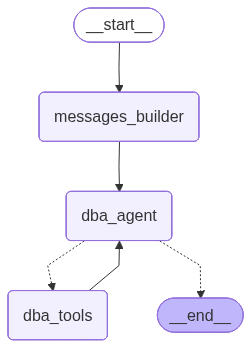

In [14]:
display(
    Image(
        react_graph.get_graph().draw_mermaid_png()
    )
)

In [15]:
db_engine = create_engine(f"sqlite:///sales.db")

In [16]:
config = {
    "configurable": {
        "db_engine": db_engine
    }
}

In [17]:
# TODO: ask the following question:
# "How many Dell XPS 15 were sold?"
inputs = {"user_query": "How many Dell XPS 15 were sold?"}

In [18]:
# TODO: Pass input and config arguments
messages = react_graph.invoke(inputs, config=config)

In [19]:
messages

{'messages': [SystemMessage(content="You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:\nFirst, find out the appropriate table name based on all tables. Then get the table's schema to understand the columns. With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. Finally, use a tool to execute the above SQL query and output the result based on the user question.", additional_kwargs={}, response_metadata={}, id='3882b8aa-d36e-4057-8a97-da87647dced8'),
  HumanMessage(content='How many Dell XPS 15 were sold?', additional_kwargs={}, response_metadata={}, id='997f201d-d97c-4502-8c04-80f531acaad9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2MTdVZsfKheEtn0i3NQGdJnL', 'function': {'arguments': '{}', 'name': 'list_tables_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 286, 'total_tokens': 297, '

In [21]:
messages['messages'][-1]

AIMessage(content='A total of 57 Dell XPS 15 units were sold.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 557, 'total_tokens': 572, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'finish_reason': 'stop', 'logprobs': None}, id='run-1141f1f1-5dbc-4767-adcb-7a9ba84cd8ec-0', usage_metadata={'input_tokens': 557, 'output_tokens': 15, 'total_tokens': 572, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [22]:
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:
First, find out the appropriate table name based on all tables. Then get the table's schema to understand the columns. With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. Finally, use a tool to execute the above SQL query and output the result based on the user question.
================================ Human Message =================================

How many Dell XPS 15 were sold?
================================== Ai Message ==================================
Tool Calls:
  list_tables_tool (call_2MTdVZsfKheEtn0i3NQGdJnL)
 Call ID: call_2MTdVZsfKheEtn0i3NQGdJnL
  Args:
================================= Tool Message =================================
Name: list_tables_tool

["sales"]
================================== Ai Message ============================

## 7. Experiment

Now that you understood how it works, experiment with new things.
- Use the tools to understand what you have in the sales.db
- Ask other questions to it
- Use your own database